In [ ]:
import initial_db
import warnings

warnings.filterwarnings("ignore")


#### Model Building

We start by visualizing the data for one room, making sure to filter so that only "occupied" points are plotted

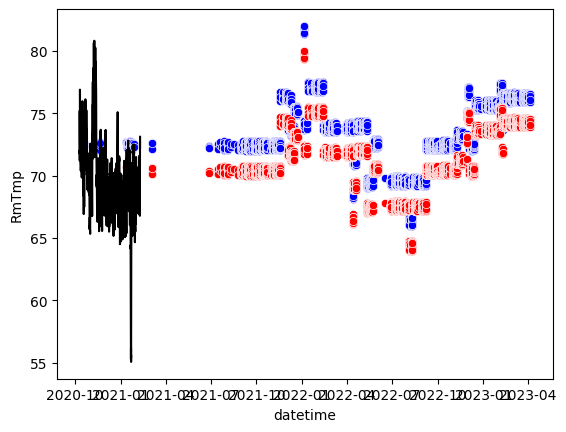

<AxesSubplot:xlabel='datetime', ylabel='RmTmp'>

In [2]:
import util
import seaborn as sns

full_df = initial_db.get_data("A3-65")

filtered_df = util.filter_setpoint(full_df)
util.graph_df_temp(full_df[:5000], filtered_df[:5000])


Next, we split the data based on occupancy and create a dataframe where each occupancy instance is a row and the column `TimeToStable` represents the amount of time it takes for the room to reach desired temperature.



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

new_df = util.split_by_occupancy(filtered_df, full_df)
agg_df = util.remove_asymptotes(new_df, full_df)
final_df = util.simplify_occurrences(agg_df)
final_df

,DprPos,FlSpt,HwVlvPos,RmTmp,RmTmpCspt,RmTmpHpst,SaFl,datetime,OaDewPt,OaHum,OaWetBlb,OaTmp,TempDiff,TimeToStable
3866,44.367188,150.0,100.000000,67.187500,72.718750,70.718750,56.0,2021-01-12 10:45:00,NaN,NaN,NaN,NaN,5.531250,45.0
4155,21.234375,150.0,100.000000,67.406250,72.750000,70.750000,89.0,2021-01-19 11:15:00,NaN,NaN,NaN,NaN,5.343750,60.0
11805,49.867188,500.0,0.000000,76.351562,72.429688,70.429688,488.0,2021-08-17 17:45:00,69.760000,38.960000,80.520000,100.590000,3.921875,15.0
13781,15.742188,150.0,53.515625,69.507812,72.609375,70.609375,138.0,2021-10-05 09:30:00,55.180000,99.850000,54.780000,54.780000,3.101562,15.0
13822,16.367188,150.0,100.000000,67.859375,72.335938,70.335938,148.0,2021-10-06 09:30:00,58.950000,84.830000,60.830000,63.610000,4.476562,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49998,15.367188,150.0,52.343750,70.906250,73.953125,71.953125,155.0,2024-04-01 16:45:00,36.538525,35.968750,49.961525,64.023438,3.046875,60.0
50052,15.945312,150.0,70.312500,70.875000,74.250000,72.250000,159.0,2024-04-03 09:45:00,32.383743,58.382812,39.811451,45.406250,3.375000,30.0
50707,15.570312,150.0,53.125000,72.210938,75.289062,73.289062,159.0,2024-04-19 09:30:00,38.559761,56.640625,45.783112,53.023438,3.078125,15.0
51199,15.242188,150.0,53.125000,71.906250,74.968750,72.968750,153.0,2024-05-01 09:30:00,45.068478,75.328125,48.197300,52.093750,3.062500,15.0


Looking at a scatterplot for this room, there appears to be a potential positive correlation between the temperature difference and time to stabilization but it is not clear.

Text(0, 0.5, 'Time to Stabilize (min)')

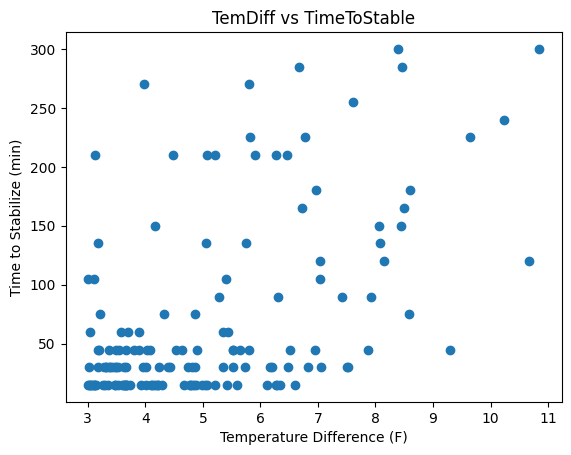

In [4]:
util.scatter_temp_diff_vs_time_room(final_df)
plt.xlabel("Temperature Difference (F)")
plt.ylabel("Time to Stabilize (min)")

Next we perform this analysis for each room we have. 

In [5]:
import os

room_list = initial_db.get_full_data_rooms()
room_list

['A2-31',
 'A3-67',
 'A3-70',
 'A2-32',
 'A3-69',
 'A2-27',
 'A3-65',
 'A2-30',
 'A2-33',
 'A3-62',
 'A2-28',
 'A3-68',
 'A3-66',
 'A2-29',
 'A3-64']

In [6]:
df_list = []

for room in room_list:
    full_df = initial_db.get_data(room)
    room_stats_path = "../data/RoomStatsCopy.csv"
    room_stats_df = pd.read_csv(room_stats_path)
    meta_full_df = util.add_meta_data(full_df, room_stats_df, room)
    filtered_df1 = util.filter_setpoint(full_df)
    filtered_df = util.split_by_occupancy(filtered_df1, full_df)
    agg_df = util.remove_asymptotes(filtered_df, full_df)
    final_df = util.simplify_occurrences(agg_df)
    df_list.append(final_df)

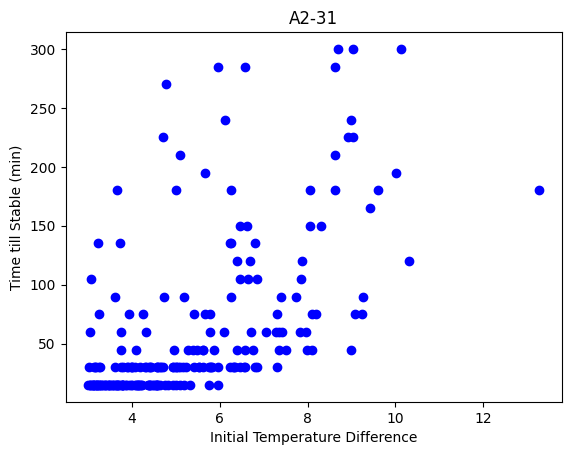

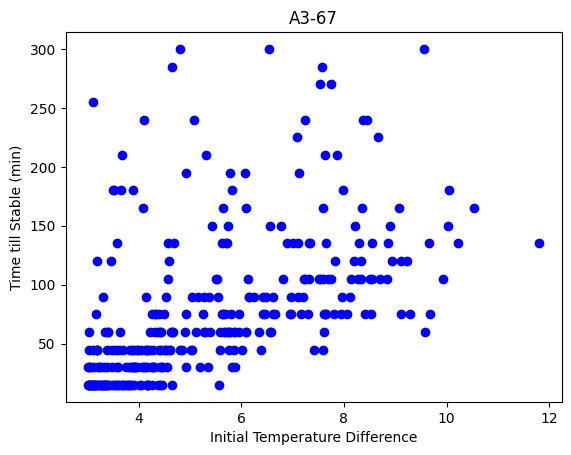

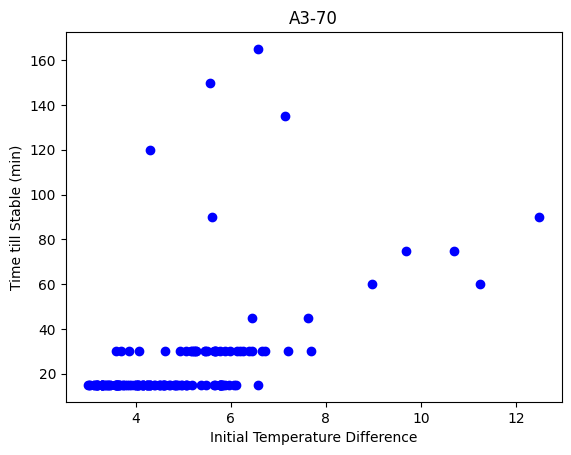

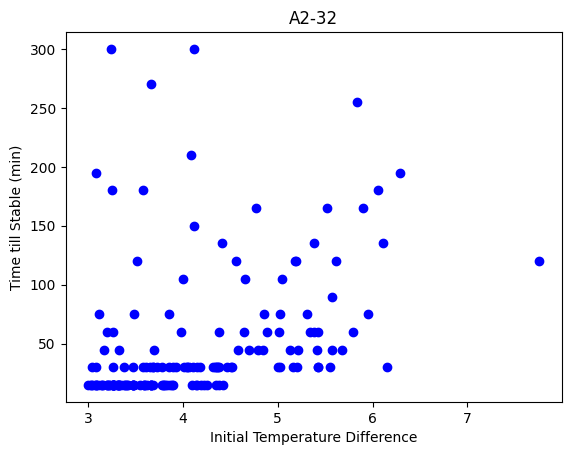

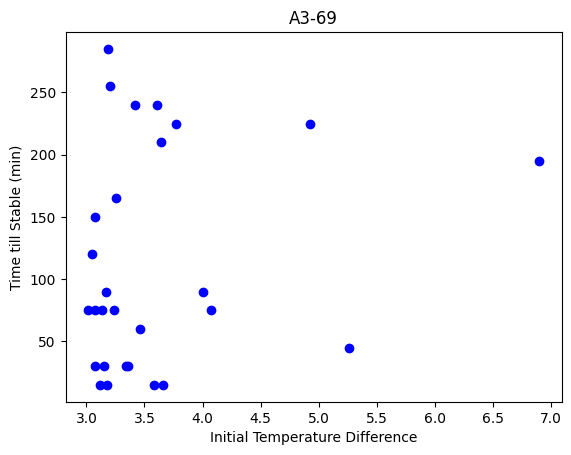

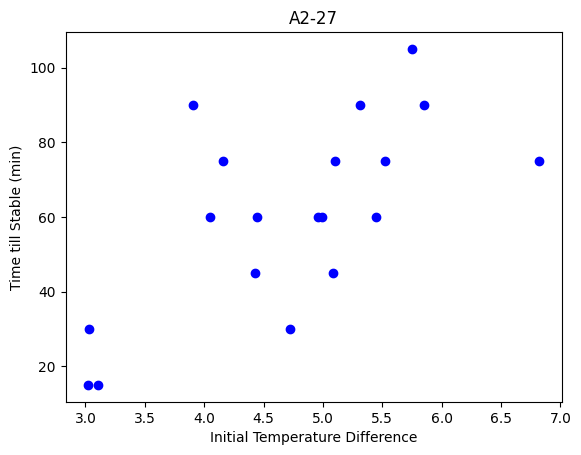

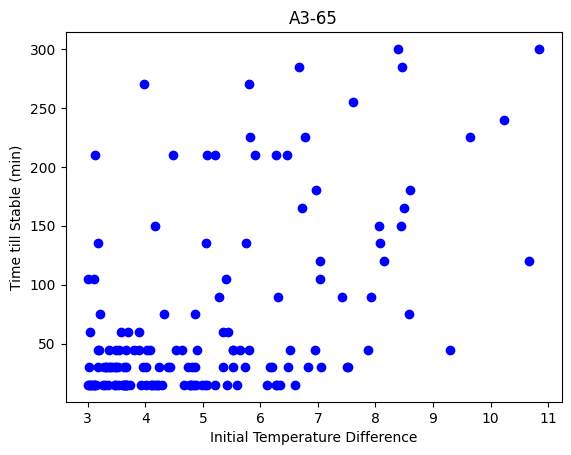

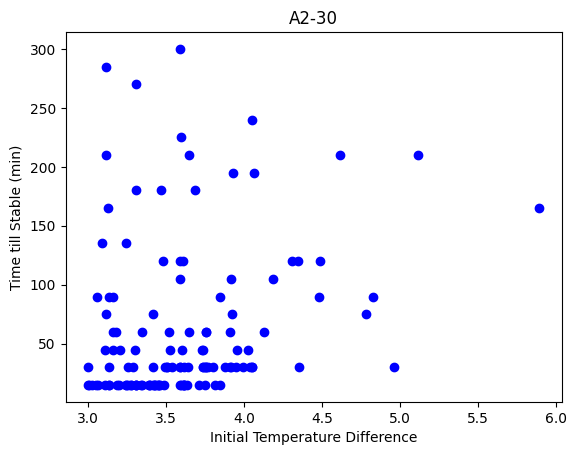

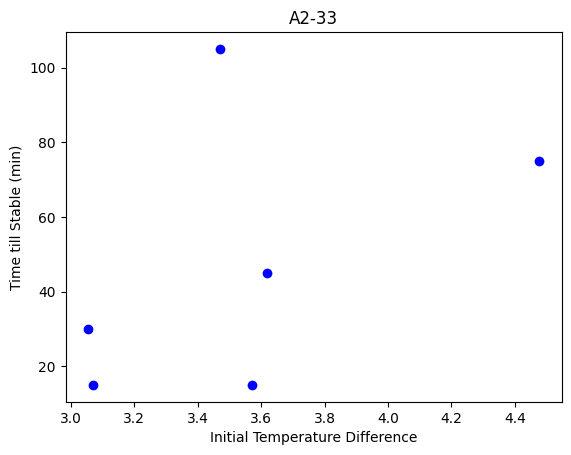

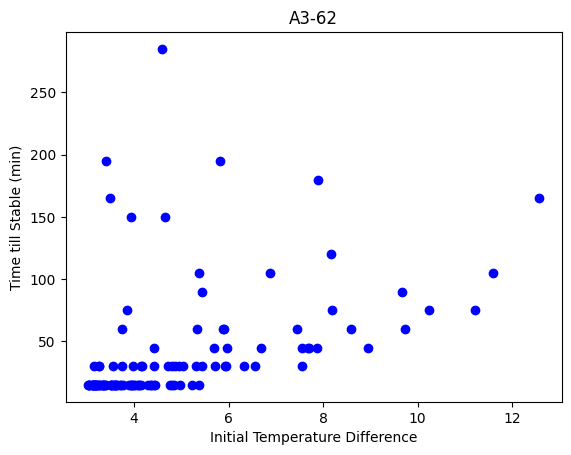

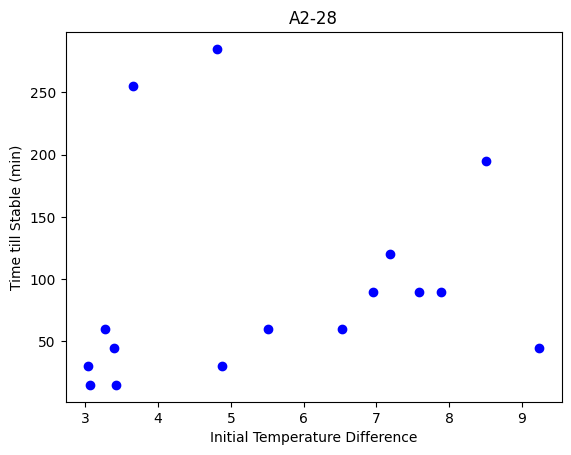

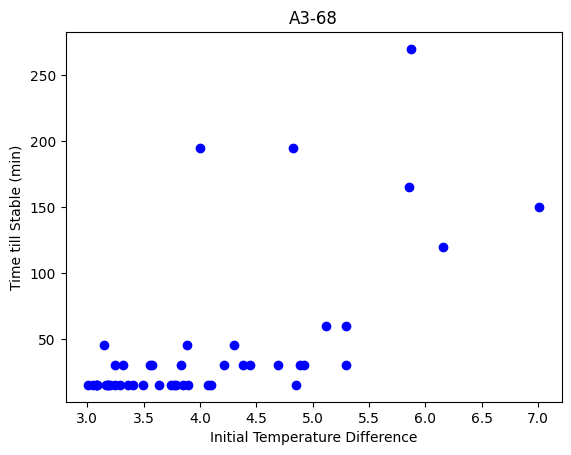

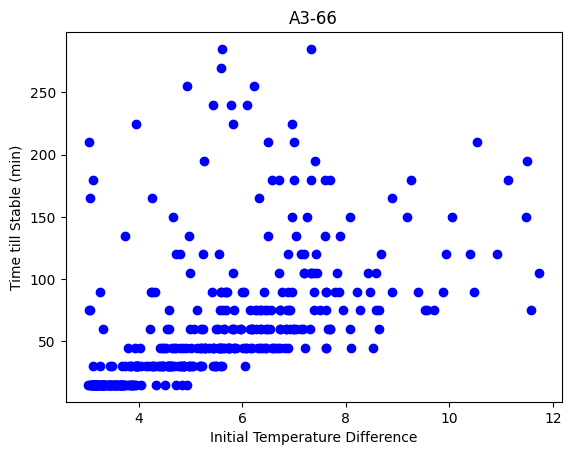

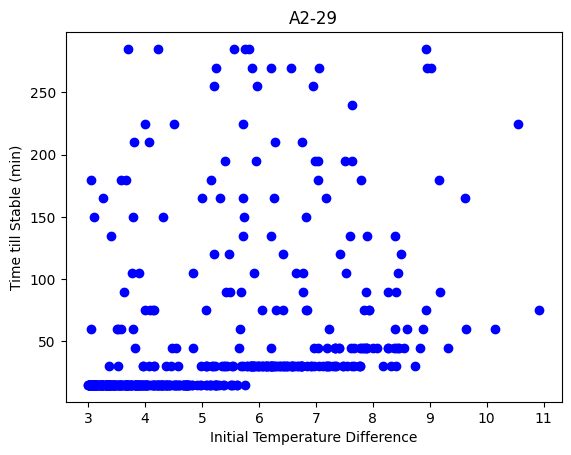

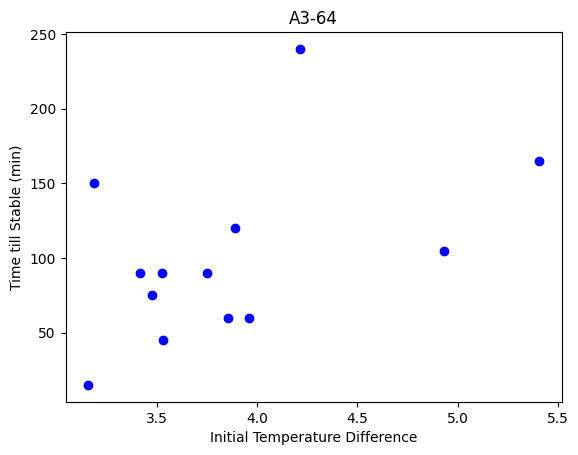

In [7]:
util.scatter_temp_diff_vs_time_all_room(df_list, room_list)

As seen here, the data is very varied per room and does not appear to have any clear correlations, especially when we plot them on top of each other, as below.

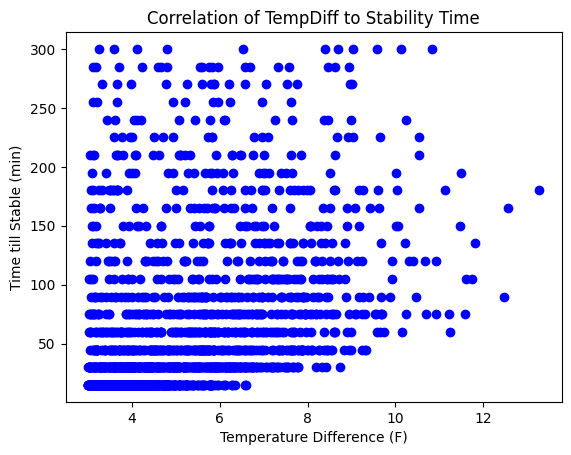

In [10]:
def scatter_temp_diff(df_list):
    for df in df_list:
        if len(df) > 0:
            plt.scatter(df.TempDiff, df.TimeToStable, c='b')
    plt.xlabel("Temperature Difference (F)")
    plt.ylabel("Time till Stable (min)")
    plt.title("Correlation of TempDiff to Stability Time")
    plt.show()

scatter_temp_diff(df_list)

Finally, we use basic modeling to see if we can estimate the time it takes to reach stability

In [11]:
new_df = util.combine_all_room_data(room_list, initial_db.get_data, "../data/RoomStatsCopy.csv")

In [12]:
import sklearn
from sklearn.linear_model import LinearRegression

reduced_df = new_df.dropna(axis=0, how='any')
reduced_df = reduced_df.drop(columns=['prof', 'idBAS', 'datetime'])

Performing feature selection, it is clear that a lot of the variables are not significant to predicting time to stabilization. The most important ones appear to be setpoint temperatures, temperature difference, and outside air data

Feature: DprPos, Score: 0.17124
Feature: FlSpt, Score: -0.03676
Feature: HwVlvPos, Score: -0.16565
Feature: RmTmp, Score: -1.28348
Feature: RmTmpCspt, Score: 22.10874
Feature: RmTmpHpst, Score: -18.88521
Feature: SaFl, Score: -0.00734
Feature: OaDewPt, Score: -1.96612
Feature: OaHum, Score: 0.33322
Feature: OaWetBlb, Score: 4.35767
Feature: OaTmp, Score: -1.56925
Feature: unoccDamper, Score: 1.32525
Feature: unoccHeat, Score: 2.42212
Feature: unoccCool, Score: -0.79984
Feature: roomSqFt, Score: -0.01039
Feature: TempDiff, Score: 14.90814


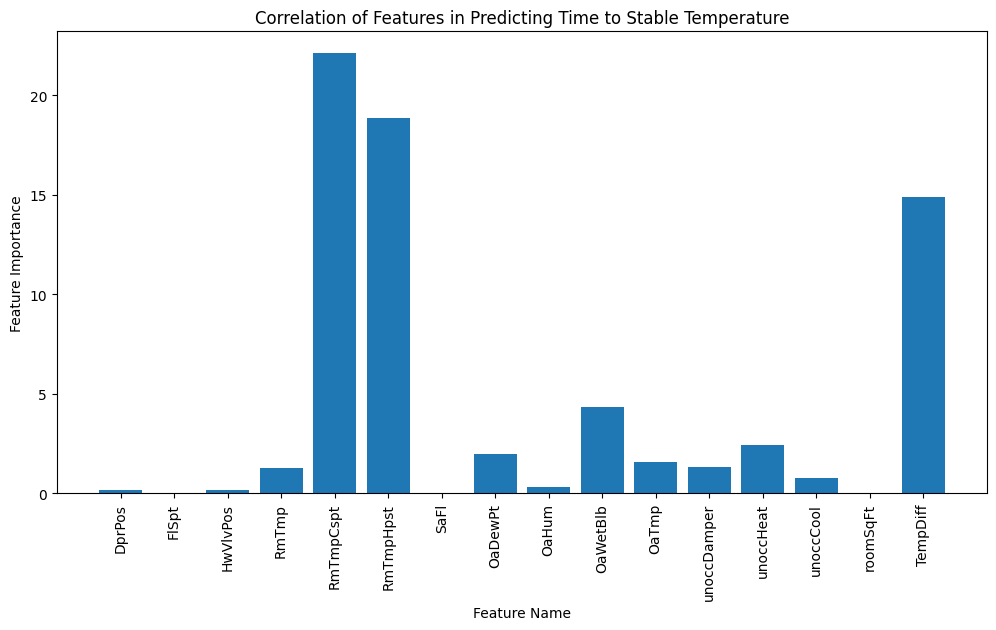

In [13]:
from sklearn.model_selection import train_test_split

X = reduced_df.drop(columns=['TimeToStable'])
y = reduced_df["TimeToStable"]

model = LinearRegression().fit(X, y)
for i in range(len(model.coef_)):
	print(f'Feature: {X.columns.to_list()[i]}, Score: %.5f' % (model.coef_[i]))

fig, ax = plt.subplots(figsize=[12, 6])
plt.xticks(rotation=90)
plt.bar(X.columns.to_list(), abs(model.coef_))
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")
plt.title("Correlation of Features in Predicting Time to Stable Temperature")
plt.show()

The following models were tested: Linear Regression, Polynomial Regression (n=2), Decision Tree Regressor

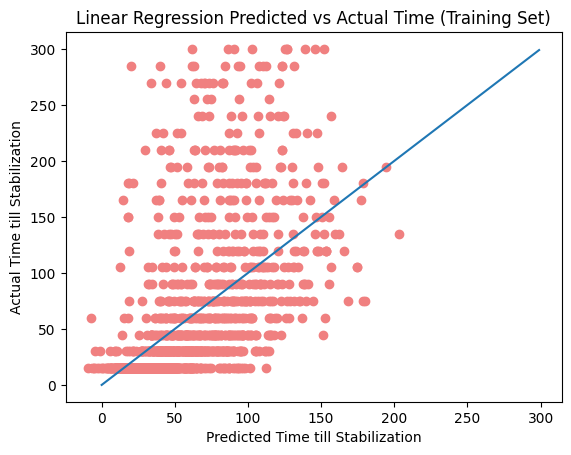

In [19]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)     # predicted value of y_test
y_pred_train = model.predict(X_train)   # predicted value of y_train

# Prediction on training set
plt.scatter(y_pred_train, y_train, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Linear Regression Predicted vs Actual Time (Training Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

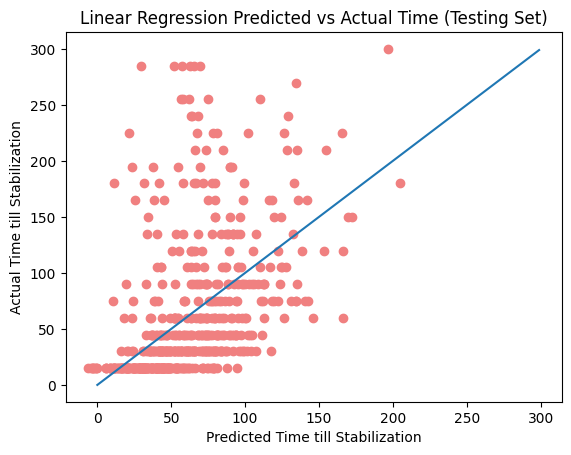

In [20]:
# Prediction on test set
plt.scatter(y_pred_test, y_test, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Linear Regression Predicted vs Actual Time (Testing Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

In [21]:
print(f"Accuracy: {sum(abs(y_pred_test - y_test) <= 15) / len(y_pred_test) * 100}%")

Accuracy: 28.667790893760543%


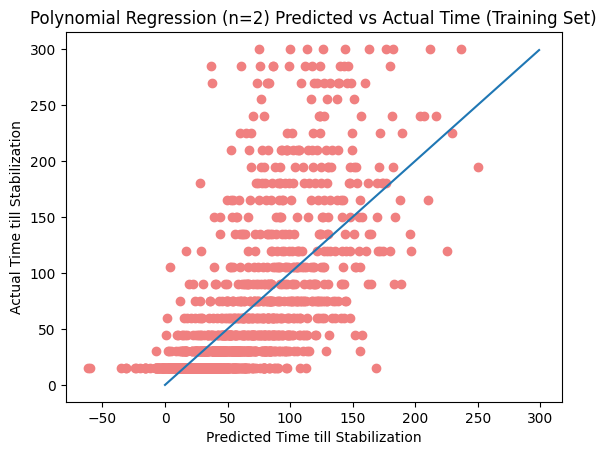

In [22]:
poly_features = PolynomialFeatures(degree=2)
model.fit(poly_features.fit_transform(X_train), y_train)

y_pred_test = model.predict(poly_features.fit_transform(X_test))     # predicted value of y_test
y_pred_train = model.predict(poly_features.fit_transform(X_train))   # predicted value of y_train

# Prediction on training set
plt.scatter(y_pred_train, y_train, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Polynomial Regression (n=2) Predicted vs Actual Time (Training Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

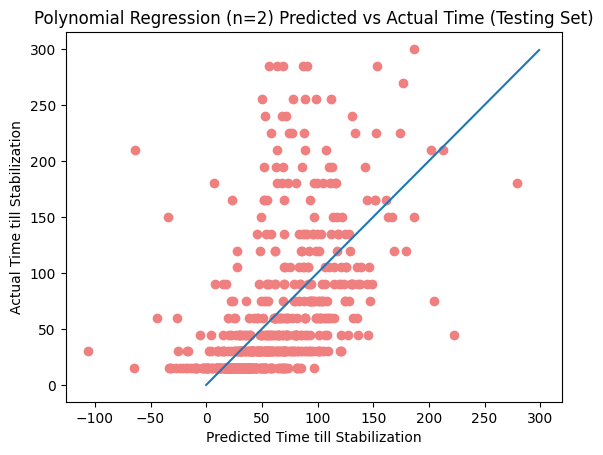

Accuracy: 31.02866779089376%


In [24]:
# Prediction on test set
plt.scatter(y_pred_test, y_test, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Polynomial Regression (n=2) Predicted vs Actual Time (Testing Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

print(f"Accuracy: {sum(abs(y_pred_test - y_test) <= 15) / len(y_pred_test) * 100}%")

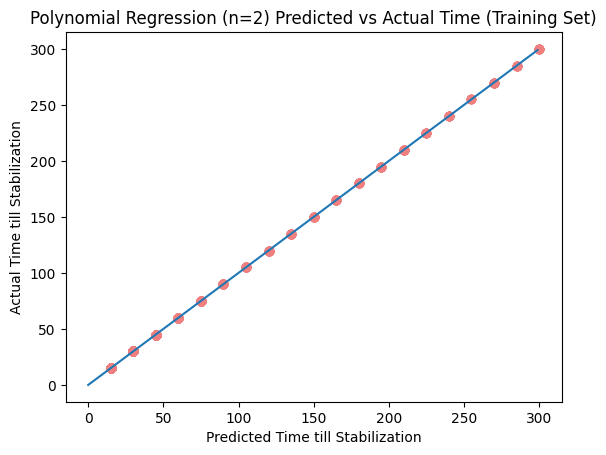

In [ ]:
model = DecisionTreeRegressor(random_state = 10)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)     # predicted value of y_test
y_pred_train = model.predict(X_train)   # predicted value of y_train

# Prediction on training set
plt.scatter(y_pred_train, y_train, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Decision Tree Regressor Predicted vs Actual Time (Training Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

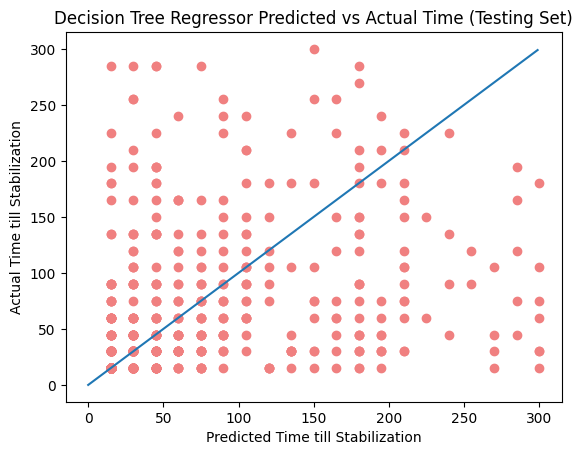

Accuracy: 53.456998313659355%


In [26]:
# Prediction on test set
plt.scatter(y_pred_test, y_test, color = 'lightcoral')
plt.plot(range(300), range(300))
plt.title('Decision Tree Regressor Predicted vs Actual Time (Testing Set)')
plt.xlabel("Predicted Time till Stabilization")
plt.ylabel("Actual Time till Stabilization")
plt.show()

print(f"Accuracy: {sum(abs(y_pred_test - y_test) <= 15) / len(y_pred_test) * 100}%")